The goal here is to compare the results of the fit to data with psychometric curves using logistic regression whenever one does the fit on different conditions *independently* or *jointly*. This notebook was done in collaboration with [Jenna Fradin](https://github.com/jennafradin), master student in the lab.

> tl; dr = Do your fits jointly on all conditions.

The rationale is that some variable which are fit are by construction similar across conditions, for instance the before-mentioned *lapse rate*, that is the frequency with which you just *miss the key*.

In this notebook, I define a fitting method using [pytorch](https://pytorch.org/) which fits in a few lines of code :

In [43]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
criterion = torch.nn.BCELoss(reduction="sum")

N_conditions = 5
bias = True
logit0_init, theta0_init, log_wt_init = -2.0, 0.0, 0.1
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, logit0_init, theta0_init, log_wt_init, bias=True):
        super(LogisticRegressionModel, self).__init__()
        if bias:
            self.theta0 = torch.nn.Parameter(theta0_init)
        else:
            self.theta0 = theta0_init
        self.logit0 = torch.nn.Parameter(logit0_init)
        self.log_wt = torch.nn.Parameter(log_wt_init)
        self.do_indep = self.logit0.shape.numel() > 1
        
    def forward(self, theta, i_condition):
        if self.do_indep:
            p0 = torch.sigmoid(self.logit0[i_condition.to(int)])
        else:
            p0 = torch.sigmoid(self.logit0)
            
        theta0 = self.theta0[i_condition.to(int)]
        wt = torch.exp(self.log_wt[i_condition.to(int)])
        out = p0 / 2 + (1 - p0) * torch.sigmoid((theta-theta0)/wt)
        return out

learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1

def fit_data(
    theta, ind_condition, y,
    logit0_init=logit0_init * torch.ones(1), 
    theta0_init=theta0_init*torch.ones(N_conditions), 
    log_wt_init=log_wt_init*torch.ones(N_conditions), 
    bias=bias,
    learning_rate=learning_rate,
    # batch_size=batch_size,  # previous notebook showed that learning_rate had no influence on performance
    num_epochs=num_epochs,
    betas=betas,
    verbose=False, **kwargs
):

    Theta, Ind_condition, labels = torch.Tensor(theta[:, None]), torch.ByteTensor(ind_condition[:, None]), torch.Tensor(y[:, None])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Theta, Ind_condition, labels = Theta.to(device), Ind_condition.to(device), labels.to(device)        
    
    logistic_model = LogisticRegressionModel(logit0_init, theta0_init, log_wt_init, bias=bias)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate, betas=betas)
            
    for epoch in range(int(num_epochs)):
        outputs = logistic_model(Theta, Ind_condition)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {loss.item() /len(theta):.5f}")
            losses = []

    logistic_model.eval()
    Theta, Ind_condition, labels = torch.Tensor(theta[:, None]), torch.Tensor(ind_condition[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta, Ind_condition)
    loss = criterion(outputs, labels).item() / len(theta)
    return logistic_model, loss

and run a series of tests to compare both methods.

<!-- TEASER_END -->

Let's first initialize the notebook:

In [2]:
from pylab import rcParams
for item in ["axes.labelsize", "font.size", "legend.fontsize"]:
    rcParams[item] = 20

import numpy as np
import matplotlib.pyplot as plt

Some hyper parameters which we will tune later:

In [4]:
N = 256 * N_conditions

N_cv = 8

seed = 1973
N_scan = 9
N_test = N * 8 # number of points for validation

bias = True

p0 = 0.1
theta0 = 0.0 * np.ones(N_conditions)
wt = np.linspace(np.pi / 32, np.pi / 8, N_conditions)

theta_max = np.pi / 2

## problem statement: a 2aFC task on synthetic data

We will generate a typical setup where we have to guess for the otientation of a visual display compared to the vertical and ask observer to either press on the `left` or `right` arrows. The visual display will be controlled by a $theta$ parameter which we draw randomly according to a Gaussian probability density function. This may be synthesized in the following *psychometric* function:


In [5]:
def psychometric_function(theta, p0=p0, theta0=theta0, wt=wt):
    return p0 / 2 + (1 - p0) / (1 + np.exp(-(theta - theta0) / wt))

such that we can draw the data according to:

In [6]:
def get_data(N=N, p0=p0, theta0=theta0, wt=wt, theta_max=theta_max, N_conditions=N_conditions, seed=seed, **kwargs):
    np.random.seed(seed)
    theta = (2 * np.random.rand(N) - 1) * theta_max
    ind_condition = np.random.randint(low=0, high=N_conditions, size=(N,))

    p = psychometric_function(theta, p0, theta0[ind_condition], wt[ind_condition])

    y = np.random.rand(N) < p  # generate data
    
    return theta, ind_condition, p, y

In [7]:
theta, ind_condition, p, y = get_data()

In [8]:
%%timeit
theta, ind_condition, p, y = get_data()

124 µs ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
theta, ind_condition, p, y = get_data()
logistic_model, loss = fit_data(theta, ind_condition, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.39064
Iteration: 16 - Loss: 0.38316
Iteration: 32 - Loss: 0.37912
Iteration: 48 - Loss: 0.37588
Iteration: 64 - Loss: 0.37337
Iteration: 80 - Loss: 0.37138
Iteration: 96 - Loss: 0.36975
Iteration: 112 - Loss: 0.36835
Iteration: 128 - Loss: 0.36710
Iteration: 144 - Loss: 0.36594
Iteration: 160 - Loss: 0.36485
Iteration: 176 - Loss: 0.36381
Iteration: 192 - Loss: 0.36283
Iteration: 208 - Loss: 0.36192
Iteration: 224 - Loss: 0.36111
Iteration: 240 - Loss: 0.36039
Iteration: 256 - Loss: 0.35979
Iteration: 272 - Loss: 0.35930
Iteration: 288 - Loss: 0.35892
Iteration: 304 - Loss: 0.35863
Iteration: 320 - Loss: 0.35841
Iteration: 336 - Loss: 0.35824
Iteration: 352 - Loss: 0.35812
Iteration: 368 - Loss: 0.35804
Iteration: 384 - Loss: 0.35797
Iteration: 400 - Loss: 0.35792
Iteration: 416 - Loss: 0.35789
Iteration: 432 - Loss: 0.35786
Iteration: 448 - Loss: 0.35784
Iteration: 464 - Loss: 0.35782
Iteration: 480 - Loss: 0.35781
Iteration: 496 - Loss: 0.35781
Iteration: 512 -

That method is fairly quick, in approx 2 seconds on my MacBook Pro (Early 2015) :

In [10]:
%%timeit
logistic_model, loss = fit_data(theta, ind_condition, y, verbose=False)

544 ms ± 262 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's compare now the retrieved values. Remember the true values used to generate the data are:

In [11]:
def npa2str(npa):
    """
    format a numpy array into a string
    """
    return ', '.join(list(map('{:.3f}'.format, npa)))

print(
    f"p0 = {p0:.3f}, theta0 = {npa2str(theta0)}, wt = {npa2str(wt)}, theta_max = {theta_max:.3f}"
)

p0 = 0.100, theta0 = 0.000, 0.000, 0.000, 0.000, 0.000, wt = 0.098, 0.172, 0.245, 0.319, 0.393, theta_max = 1.571


This is what we get out of our method:

In [12]:
def get_params(logistic_model, verbose=False):
    theta0_ = logistic_model.theta0.detach().numpy()
    wt_ = torch.exp(logistic_model.log_wt).detach().numpy()
    p0_ = torch.sigmoid(logistic_model.logit0).detach().numpy()
    N_conditions = wt_.shape[0]
    if verbose:
        #for i_condition in range(N_conditions):
        #    print(f'-> i_condition={i_condition}')
        #    if bias:
        #        print(f"theta0 = {theta0_[i_condition]:.3f}")
        #    print(f"slope = {wt_[i_condition]:.3f}")
        if bias:
            print(f"theta0 = {npa2str(theta0_)}")
        print(f"slope = {npa2str(wt_)}")
        print(f"p0 = {npa2str(p0_)}")
    return theta0_, wt_, p0_


theta0_, wt_, p0_ = get_params(logistic_model, verbose=True)

theta0 = -0.023, -0.032, 0.059, 0.016, -0.043
slope = 0.045, 0.166, 0.313, 0.296, 0.408
p0 = 0.095


let's do the same thing with on every condition *independently*: 

In [13]:
logistic_model_indep, loss = fit_data(theta, ind_condition, y, logit0_init=logit0_init * torch.ones(N_conditions), verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.35853
Iteration: 16 - Loss: 0.35793
Iteration: 32 - Loss: 0.35765
Iteration: 48 - Loss: 0.35747
Iteration: 64 - Loss: 0.35733
Iteration: 80 - Loss: 0.35721
Iteration: 96 - Loss: 0.35712
Iteration: 112 - Loss: 0.35703
Iteration: 128 - Loss: 0.35695
Iteration: 144 - Loss: 0.35689
Iteration: 160 - Loss: 0.35682
Iteration: 176 - Loss: 0.35677
Iteration: 192 - Loss: 0.35672
Iteration: 208 - Loss: 0.35667
Iteration: 224 - Loss: 0.35663
Iteration: 240 - Loss: 0.35659
Iteration: 256 - Loss: 0.35656
Iteration: 272 - Loss: 0.35653
Iteration: 288 - Loss: 0.35650
Iteration: 304 - Loss: 0.35647
Iteration: 320 - Loss: 0.35644
Iteration: 336 - Loss: 0.35642
Iteration: 352 - Loss: 0.35640
Iteration: 368 - Loss: 0.35638
Iteration: 384 - Loss: 0.35636
Iteration: 400 - Loss: 0.35634
Iteration: 416 - Loss: 0.35632
Iteration: 432 - Loss: 0.35630
Iteration: 448 - Loss: 0.35629
Iteration: 464 - Loss: 0.35627
Iteration: 480 - Loss: 0.35626
Iteration: 496 - Loss: 0.35625
Iteration: 512 -

In [14]:
theta0_indep_, wt_indep_, p0_indep_ = get_params(logistic_model_indep, verbose=True)

theta0 = -0.023, -0.034, 0.042, 0.035, -0.062
slope = 0.045, 0.157, 0.260, 0.352, 0.465
p0 = 0.094, 0.113, 0.150, 0.030, 0.027


... TODO: describe

## qualitative comparison of methods

We can synthesize this comparison by drawing a new dataset and plotting the psychometric curves which are obtained by each method

In [15]:
theta, ind_condition, p, y = get_data()  # nouvelles données
logistic_model, loss = fit_data(theta, ind_condition, y, verbose=False)
print(f"Training jointly - loss = {loss:.3f}")
logistic_model_indep, loss_indep = fit_data(theta, ind_condition, y, logit0=logit0_init * torch.ones(N_conditions), verbose=False)
print(f"Training independently - loss = {loss_indep:.3f}")

Training jointly - loss = 0.358
Training independently - loss = 0.358


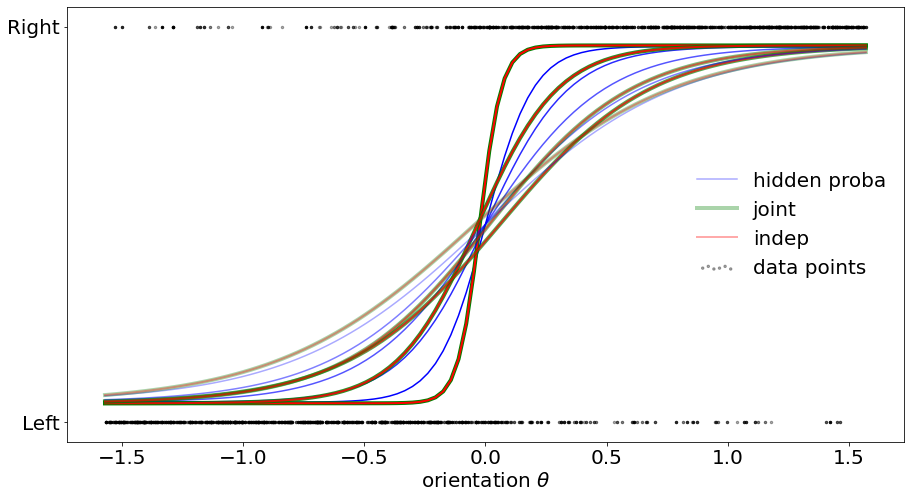

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))
#colors = plt.cm.inferno(np.linspace(1, .2, len(B_thetas))) #tc colormap

for i_condition in range(N_conditions):
    alpha = 1 - i_condition / (N_conditions+1)
    mask = ind_condition==i_condition
    do_label = i_condition==N_conditions-1
    l = ax.scatter(theta[mask], y[mask], s=6, alpha=alpha, color='k') # , alpha=1./ind_condition
    if do_label: l.set_label("data points")    
    x_values = np.linspace(-theta_max, theta_max, 100)
    y_values_p = psychometric_function(x_values, p0, theta0[i_condition], wt[i_condition])
    l = ax.plot(x_values, y_values_p, alpha=alpha, color="b")
    if do_label: l[0].set_label("hidden proba")
    y_values = logistic_model(torch.Tensor(x_values), torch.ByteTensor(i_condition*np.ones_like(x_values))).detach().numpy()
    l = ax.plot(x_values, y_values, "g", alpha=alpha, lw=4)
    if do_label: l[0].set_label("joint")
    y_values_indep = logistic_model_indep(torch.Tensor(x_values), torch.ByteTensor(i_condition*np.ones_like(x_values))).detach().numpy()
    l = ax.plot(x_values, y_values_indep, "r", alpha=alpha, lw=2)
    if do_label: l[0].set_label("indep")
ax.set_xlabel(r"orientation $\theta$", fontsize=20)
ax.set_yticks([0.0, 1.0])
ax.set_yticklabels(["Left", "Right"], fontsize=20)
plt.legend(fontsize=20, frameon=False, scatterpoints=6);

There is a clear discrepency between the classical logistic function obtained by logistic regression (here, the implementation by `sklearn`) and that obtained by our more detailed model. In particular, the slope is more sharp, a feature which may be important for cognitive processes. But what is the origin of this discrepancy? Is it  the numerical optimization method? Is it the generative model?

This are the question we try to resolve here. First, let's retrieve a measure for how well the extracted psychometric curve represent the data: the *losses*.

In [17]:
theta, ind_condition, p, y = get_data(N=N_test, seed=seed + N_test)

In [18]:
logistic_model, loss = fit_data(theta, ind_condition, y, verbose=False)
print(f"Training jointly - loss = {loss:.3f}")

Training jointly - loss = 0.354


In [19]:
logistic_model_indep, loss_indep = fit_data(theta, ind_condition, y, logit0=logit0_init * torch.ones(N_conditions), verbose=False)
print(f"Training independently - loss = {loss_indep:.3f}")

Training independently - loss = 0.354


The units for these losses are *bits*. Indeed, they represent some value of information about the binary data "$d$" and the continuous psychometric curve "$p$". This information is equal to $\log_2(p)$ if $d=1$ and $\log_2(1-p)$ if $d=0$. Putting things together, we obtain the [Binary Cross Entropy](https://pytorch.org/docs/stable/nn.html#bceloss) and if we index datapoints by $k$:

$$
\mathcal{L} = \sum_k d_k \cdot \log_2(p_k) + (1-d_k) \cdot \log_2(1-p_k)
$$

You can see that this measure is a form of [Cross_entropy](https://en.wikipedia.org/wiki/Cross_entropy), adapted to binary datapoints.

The losses which were computed above are those obtained during training. Relying on this value may be a dangerous strategy as the model may be overfitting the data. We should therefore measure how the model would generalize with novel data.

While it hard to do with real (experimental) data which are often scarse, here we synthesized the data and we can thus compute a testing loss by drawing again a set of new data and computing the loss on that data:

In [20]:
def loss_torch(logistic_model, theta, ind_condition, p, y):
    labels = torch.Tensor(y)
    Theta = torch.Tensor(theta)
    P = torch.Tensor(p)

    outputs = logistic_model(Theta, torch.ByteTensor(ind_condition))
    return criterion(outputs, labels).item() / len(theta)


print(f"Testing jointly - loss = {loss_torch(logistic_model, theta, ind_condition, p, y):.3f}")

Testing jointly - loss = 0.354


In [21]:

print(f"Testing independently - loss = {loss_torch(logistic_model_indep, theta, ind_condition, p, y):.3f}")

Testing independently - loss = 0.354


Finally, as we synthesized the data, we can compute the loss on that data with the "true" psychometric curve, giving to us the baseline number one can achieve:

In [22]:
def loss_true(theta, p, y):
    labels = torch.Tensor(y[:, None])
    P = torch.Tensor(p[:, None])
    return criterion(P, labels).item() / len(theta)


print(f"Testing true loss = {loss_true(theta, p, y):.3f}")

Testing true loss = 0.355



We are now equipped to make quantitative comparisons. Let's first explore the parameters of the methods.

## quantitative comparison of methods : varrying methods' parameters

Let's study the influence of each method's meta-parameter, such as the number of iterations. As I learn to use [python decorators](https://realpython.com/primer-on-python-decorators/#a-few-real-world-examples), I will use plenty of them:

In [23]:
import functools
import time

def timer(func):
    """Print the runtime of the decorated function"""
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()    # 1
        results = func(*args, **kwargs)
        end_time = time.perf_counter()      # 2
        run_time = end_time - start_time    # 3
        print(f"Finished {func.__name__!r} in {run_time:.4f} secs")
        return results
    return wrapper_timer

### influence of learning rate


In [24]:
default_dict = dict(learning_rate=learning_rate,
                    num_epochs=num_epochs,
                    betas=betas,
                    N=N, p0=p0, theta0=theta0, wt=wt, theta_max=theta_max, seed=seed,
                    logit0_init=logit0_init * torch.ones(1), 
                    theta0_init=theta0_init*torch.ones(N_conditions), 
                    log_wt_init=torch.log(log_wt_init*torch.ones(N_conditions)), 
                   )

In [25]:
#@timer
def explore_param(default_dict, variable, var_range, do_fit=True, do_indep=True):
    results = np.zeros((4, len(var_range), N_cv))
    timings = []

    for i_var, var_ in enumerate(var_range):
        kwarg = default_dict.copy()
        kwarg[variable] = var_
        kwarg['verbose'] = False

        for i_CV in range(N_cv):
            
            kwarg.update(seed=seed + i_CV)
            theta, ind_condition, p, y = get_data(**kwarg)

            tic = time.time()
            if do_fit: logistic_model, loss = fit_data(theta, ind_condition, y, **kwarg)
                
            if do_indep: 
                kwarg['logit0_init'] = logit0_init * torch.ones(N_conditions)
                logistic_model_indep, loss_indep = fit_data(theta, ind_condition, y, **kwarg)
            toc = time.time()

            if N_test > 0:
                kwarg.update(N=N_test, seed=seed + i_CV + N_test)
                theta, ind_condition, p, y = get_data(**kwarg)
                if do_fit: loss = loss_torch(logistic_model, theta, ind_condition, p, y)
                if do_indep: loss_indep = loss_torch(logistic_model_indep, theta, ind_condition, p, y)

            results[0, i_var, i_CV] = loss_true(theta, p, y)
            if do_fit: results[1, i_var, i_CV] = loss
            if do_indep: results[2, i_var, i_CV] = loss_indep
            results[3, i_var, i_CV] = toc-tic
        out_str = f"{variable}: {var_:.5f}, Loss (true): {np.mean(results[0, i_var, :]):.5f}"
        if do_fit: out_str = f"{out_str}, loss_indep: {np.mean(results[1, i_var, :]):.5f}"
        if do_indep: out_str = f"{out_str}, loss_joint: {np.mean(results[2, i_var, :]):.5f}"
        print(out_str)

    return results

In [26]:
learning_rates = learning_rate * np.logspace(-2, 1, N_scan, base=10)
results = explore_param(default_dict, variable='learning_rate', var_range=learning_rates)

learning_rate: 0.00005, Loss (true): 0.36027, loss_indep: 0.37979, loss_joint: 0.38027
learning_rate: 0.00012, Loss (true): 0.36027, loss_indep: 0.36379, loss_joint: 0.36402
learning_rate: 0.00028, Loss (true): 0.36027, loss_indep: 0.36108, loss_joint: 0.36108
learning_rate: 0.00067, Loss (true): 0.36027, loss_indep: 0.36113, loss_joint: 0.36115
learning_rate: 0.00158, Loss (true): 0.36027, loss_indep: 0.36133, loss_joint: 0.36138
learning_rate: 0.00375, Loss (true): 0.36027, loss_indep: 0.36144, loss_joint: 0.36150
learning_rate: 0.00889, Loss (true): 0.36027, loss_indep: 0.36147, loss_joint: 0.36158
learning_rate: 0.02108, Loss (true): 0.36027, loss_indep: 0.36150, loss_joint: 0.36162
learning_rate: 0.05000, Loss (true): 0.36027, loss_indep: 0.36151, loss_joint: 0.36164


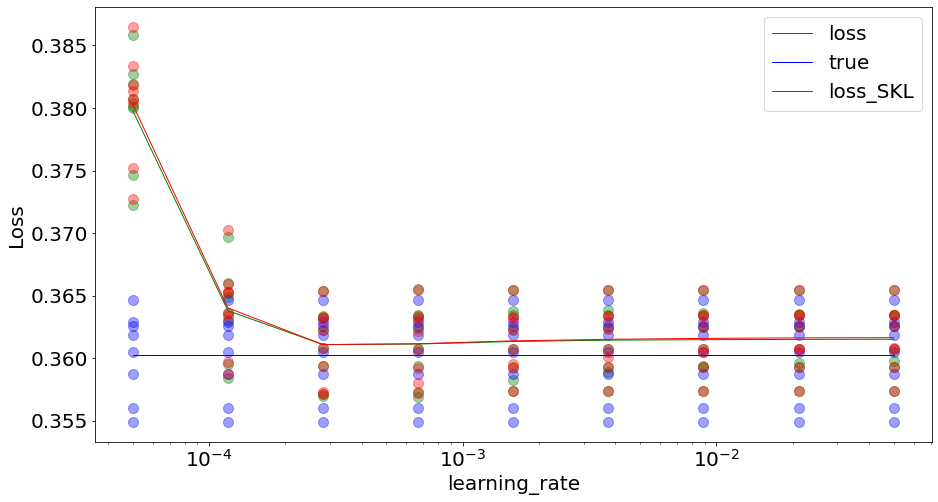

In [27]:
def plot_explore_param(variable, var_range, results, do_norm=False):
    opts_scat = dict(marker=".", lw=0, alpha=3 / N_cv, ms=20)
    opts_line = dict(lw=1, alpha=1)
    
    if do_norm:
        norm = results[0, :, :]
    else:
        norm = 1
        
    fig, ax = plt.subplots(figsize=(15, 8))
    if results[1, ...].sum()>0: ax.plot(var_range, results[1, :, :]/norm, **opts_scat, color="green")
    ax.plot(var_range, results[0, :, :]/norm, **opts_scat, color="blue")
    if results[2, ...].sum()>0: ax.plot(var_range, results[2, :, :]/norm, **opts_scat, color="red")

    if results[1, ...].sum()>0: ax.plot(var_range, np.mean(results[1, :, :]/norm, axis=-1), **opts_line, color="green", label="loss")
    ax.plot(var_range, np.mean(results[0, :, :]/norm, axis=-1), **opts_line, color="blue", label="true")
    if results[2, ...].sum()>0: ax.plot(var_range, np.mean(results[2, :, :]/norm, axis=-1), **opts_line, color="red", label="loss_SKL")

    # ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))

    ax.set_xlabel(variable)
    ax.set_ylabel("Loss")
    ax.set_xscale("log")
    ax.legend(loc="best")
    return fig, ax

fig, ax = plot_explore_param(variable='learning_rate', var_range=learning_rates, results=results)

We are at a sweet spot with our learning rate, still it is valid on a wide range. 

### influence du nombre d'epochs

In [28]:
num_epochss = num_epochs * np.logspace(-2, 1, N_scan, base=10)
num_epochss = [int(num_epochs_) for num_epochs_ in num_epochss]

results = explore_param(default_dict, variable='num_epochs', var_range=num_epochss, do_indep=False)

num_epochs: 5.00000, Loss (true): 0.36027, loss_indep: 0.36077
num_epochs: 12.00000, Loss (true): 0.36027, loss_indep: 0.36078
num_epochs: 28.00000, Loss (true): 0.36027, loss_indep: 0.36083
num_epochs: 68.00000, Loss (true): 0.36027, loss_indep: 0.36089
num_epochs: 162.00000, Loss (true): 0.36027, loss_indep: 0.36104
num_epochs: 384.00000, Loss (true): 0.36027, loss_indep: 0.36116
num_epochs: 912.00000, Loss (true): 0.36027, loss_indep: 0.36124
num_epochs: 2163.00000, Loss (true): 0.36027, loss_indep: 0.36124
num_epochs: 5130.00000, Loss (true): 0.36027, loss_indep: 0.36124


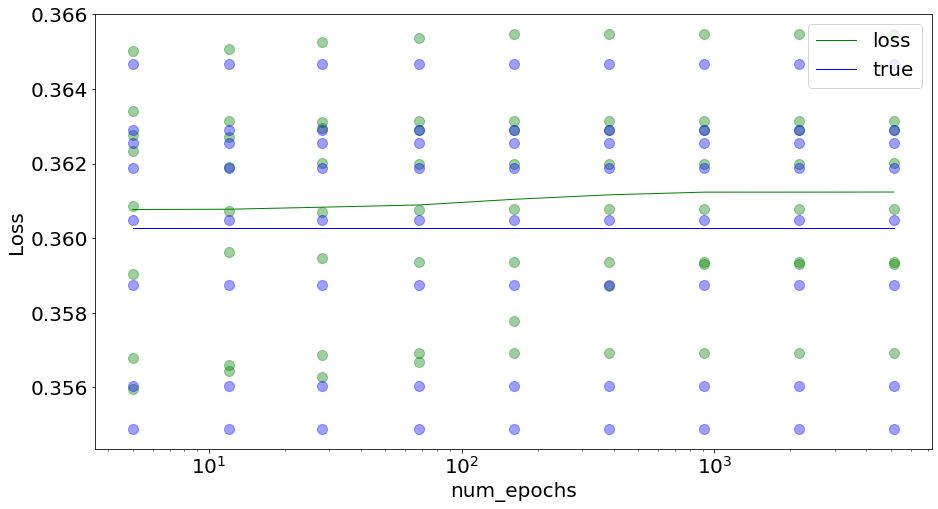

In [29]:
fig, ax = plot_explore_param(variable='num_epochs', var_range=num_epochss, results=results)

Similarly, we are at a sweet spot with our number of epochs, and this is true for both methods. 

### influence of `beta1`

In [30]:
beta1s = 1.0 - np.logspace(-3, -2, N_scan, base=10, endpoint=True)
results = explore_param(default_dict, variable='beta1', var_range=beta1s, do_indep=False)

beta1: 0.99900, Loss (true): 0.36027, loss_indep: 0.36120
beta1: 0.99867, Loss (true): 0.36027, loss_indep: 0.36120
beta1: 0.99822, Loss (true): 0.36027, loss_indep: 0.36120
beta1: 0.99763, Loss (true): 0.36027, loss_indep: 0.36120
beta1: 0.99684, Loss (true): 0.36027, loss_indep: 0.36120
beta1: 0.99578, Loss (true): 0.36027, loss_indep: 0.36120
beta1: 0.99438, Loss (true): 0.36027, loss_indep: 0.36120
beta1: 0.99250, Loss (true): 0.36027, loss_indep: 0.36120
beta1: 0.99000, Loss (true): 0.36027, loss_indep: 0.36120


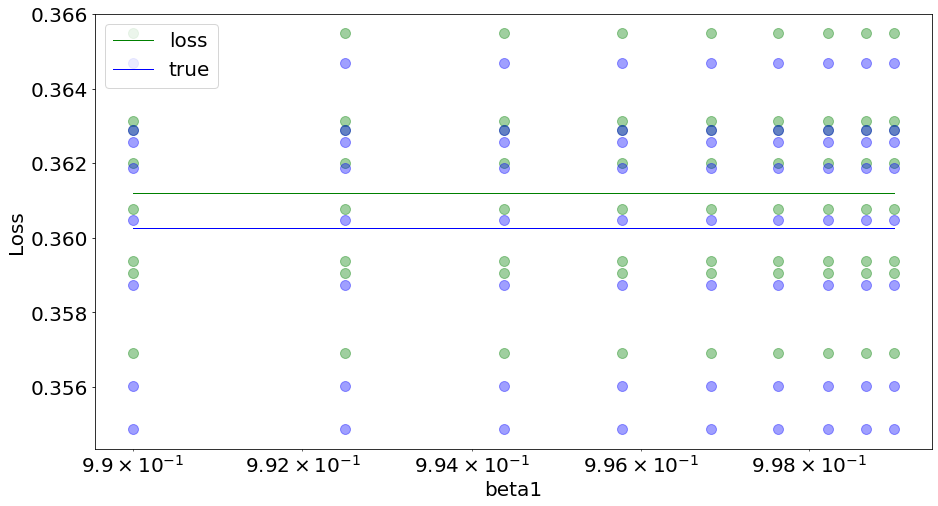

In [31]:
fig, ax = plot_explore_param(variable='beta1', var_range=beta1s, results=results)

The influence of this parameter is limited, such that using `Adam` is perhaps overkill. A simple `SGD` should be tested. Similarly, for `beta2`:

### influence of `beta2`

In [32]:
beta2s = 1.0 - np.logspace(-7, -2, N_scan, base=10, endpoint=True)
results = explore_param(default_dict, variable='beta2', var_range=beta2s, do_indep=False)

beta2: 1.00000, Loss (true): 0.36027, loss_indep: 0.36120
beta2: 1.00000, Loss (true): 0.36027, loss_indep: 0.36120
beta2: 1.00000, Loss (true): 0.36027, loss_indep: 0.36120
beta2: 0.99999, Loss (true): 0.36027, loss_indep: 0.36120
beta2: 0.99997, Loss (true): 0.36027, loss_indep: 0.36120
beta2: 0.99987, Loss (true): 0.36027, loss_indep: 0.36120
beta2: 0.99944, Loss (true): 0.36027, loss_indep: 0.36120
beta2: 0.99763, Loss (true): 0.36027, loss_indep: 0.36120
beta2: 0.99000, Loss (true): 0.36027, loss_indep: 0.36120


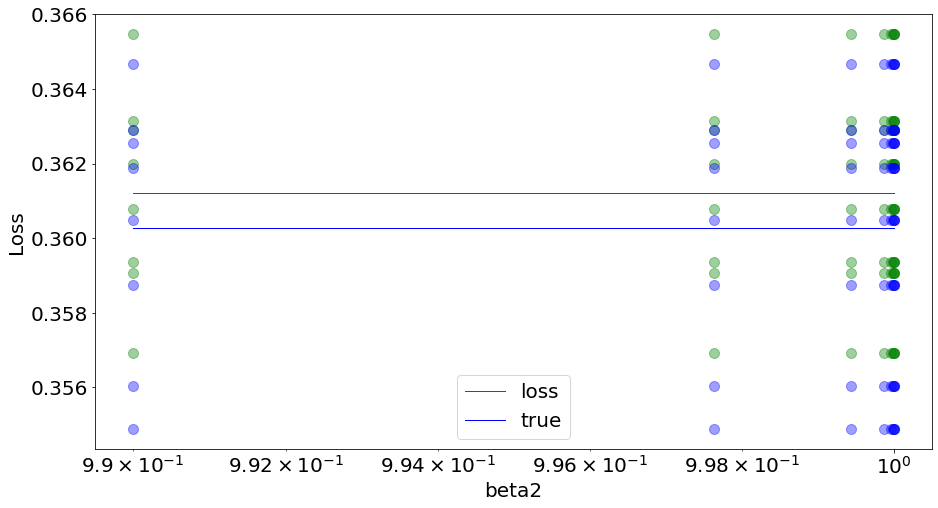

In [33]:
fig, ax = plot_explore_param(variable='beta2', var_range=beta2s, results=results)


## quantitative comparison of methods : varrying experimental parameters

Now that we now more about methodological parameters, let's study more crucial parameters like that of the experiment.


### influence of number of trials

The number of trials is crucial as if defines the number of our datapoints, and also the length of the experiment. This is important as we want to make this number as low as possible. Indeed, observers doing the experiment, for example a master student in front of the computer screen, may experience fatigue which would prevent accurate recordings.

In [34]:
Ns = np.logspace(1.5, 3, N_scan, base=10, endpoint=True)
Ns = [int(Ns_) for Ns_ in Ns]

results = explore_param(default_dict, variable='N', var_range=Ns)

N: 31.00000, Loss (true): 0.36027, loss_indep: 0.37969, loss_joint: 0.37727
N: 48.00000, Loss (true): 0.36027, loss_indep: 0.40361, loss_joint: 0.38800
N: 74.00000, Loss (true): 0.36027, loss_indep: 0.39610, loss_joint: 0.37345
N: 115.00000, Loss (true): 0.36027, loss_indep: 0.42903, loss_joint: 0.37226
N: 177.00000, Loss (true): 0.36027, loss_indep: 0.37166, loss_joint: 0.36494
N: 273.00000, Loss (true): 0.36027, loss_indep: 0.37456, loss_joint: 0.36267
N: 421.00000, Loss (true): 0.36027, loss_indep: 0.37694, loss_joint: 0.36296
N: 649.00000, Loss (true): 0.36027, loss_indep: 0.36942, loss_joint: 0.36265
N: 1000.00000, Loss (true): 0.36027, loss_indep: 0.36948, loss_joint: 0.36206


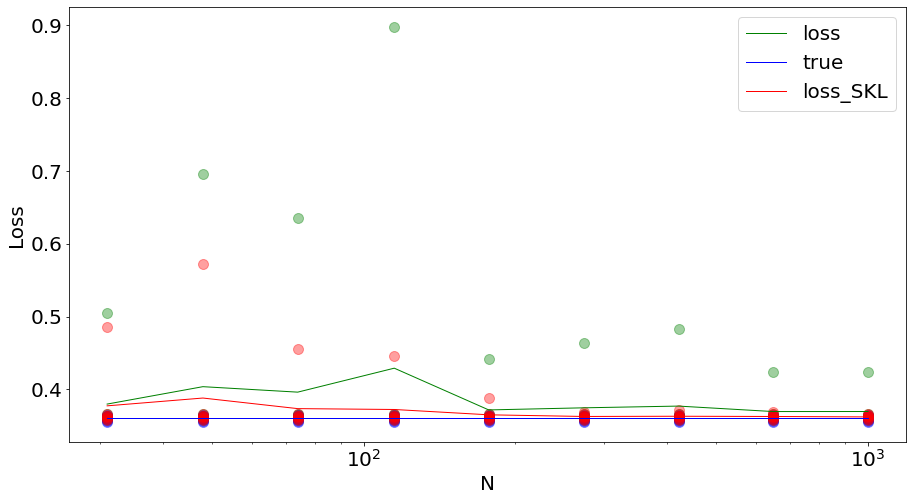

In [35]:
fig, ax = plot_explore_param(variable='N', var_range=Ns, results=results)

As a consequence, $20$ trials is not enough and $100$ is OK. This depends on our expectations on the the retrieved data.

### influence of theta_max

The convergence of the fitting procedure may also depend on the parametrers of the data which were set to:

In [36]:
print(
    f"p0 = {npa2str([p0])}, theta0 = {npa2str(theta0)}, wt = {npa2str(wt)}, theta_max = {theta_max:.3f}"
)

p0 = 0.100, theta0 = 0.000, 0.000, 0.000, 0.000, 0.000, wt = 0.098, 0.172, 0.245, 0.319, 0.393, theta_max = 1.571


One of this is `theta_max` and is describing the "width" of tested orientation values:

In [37]:
theta_maxs = theta_max * np.logspace(-1, 1, N_scan, base=2, endpoint=True)

results = explore_param(default_dict, variable='theta_max', var_range=theta_maxs)

theta_max: 0.78540, Loss (true): 0.47937, loss_indep: 0.48353, loss_joint: 0.48141
theta_max: 0.93400, Loss (true): 0.44828, loss_indep: 0.45007, loss_joint: 0.45013
theta_max: 1.11072, Loss (true): 0.41830, loss_indep: 0.42001, loss_joint: 0.42008
theta_max: 1.32088, Loss (true): 0.38884, loss_indep: 0.39025, loss_joint: 0.39042
theta_max: 1.57080, Loss (true): 0.36027, loss_indep: 0.36145, loss_joint: 0.36153
theta_max: 1.86800, Loss (true): 0.33514, loss_indep: 0.33622, loss_joint: 0.33631
theta_max: 2.22144, Loss (true): 0.31288, loss_indep: 0.31408, loss_joint: 0.31425
theta_max: 2.64175, Loss (true): 0.29457, loss_indep: 0.29551, loss_joint: 0.29579
theta_max: 3.14159, Loss (true): 0.28031, loss_indep: 0.28152, loss_joint: 0.28179


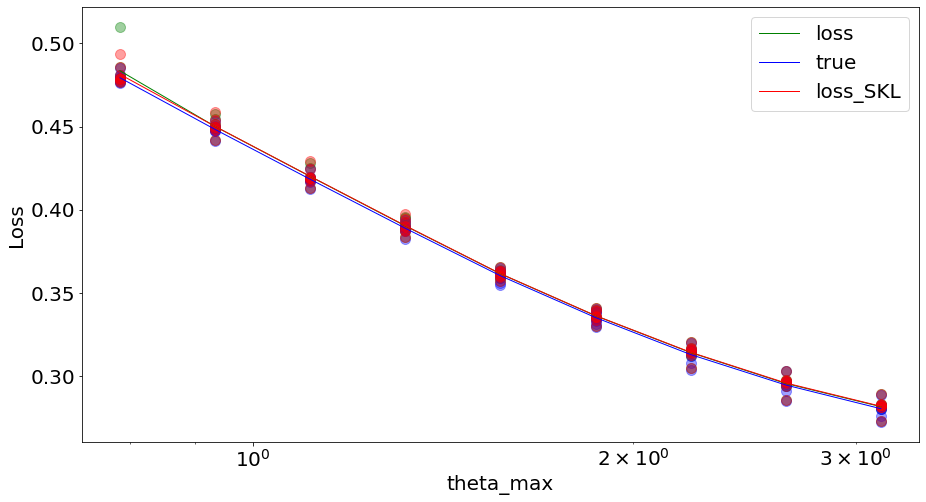

In [38]:
fig, ax = plot_explore_param(variable='theta_max', var_range=theta_maxs, results=results)

The value of  `theta_max` as a clear influence on the loss in particular for classical logistic regression (`sklearn`) which will have a problem with datapoints caused by the lapse rate `p0`.

### influence of `p0`



In [39]:
p0s = np.logspace(-3, -0.7, N_scan, base=10, endpoint=True)

results = explore_param(default_dict, variable='p0', var_range=p0s)


p0: 0.00100, Loss (true): 0.24997, loss_indep: 0.25193, loss_joint: 0.25374
p0: 0.00194, Loss (true): 0.25116, loss_indep: 0.25284, loss_joint: 0.25477
p0: 0.00376, Loss (true): 0.25355, loss_indep: 0.25507, loss_joint: 0.25678
p0: 0.00729, Loss (true): 0.25895, loss_indep: 0.26024, loss_joint: 0.26144
p0: 0.01413, Loss (true): 0.26762, loss_indep: 0.26876, loss_joint: 0.26941
p0: 0.02738, Loss (true): 0.28354, loss_indep: 0.28437, loss_joint: 0.28460
p0: 0.05309, Loss (true): 0.31323, loss_indep: 0.31399, loss_joint: 0.31398
p0: 0.10292, Loss (true): 0.36300, loss_indep: 0.36423, loss_joint: 0.36437
p0: 0.19953, Loss (true): 0.44343, loss_indep: 0.44498, loss_joint: 0.44506


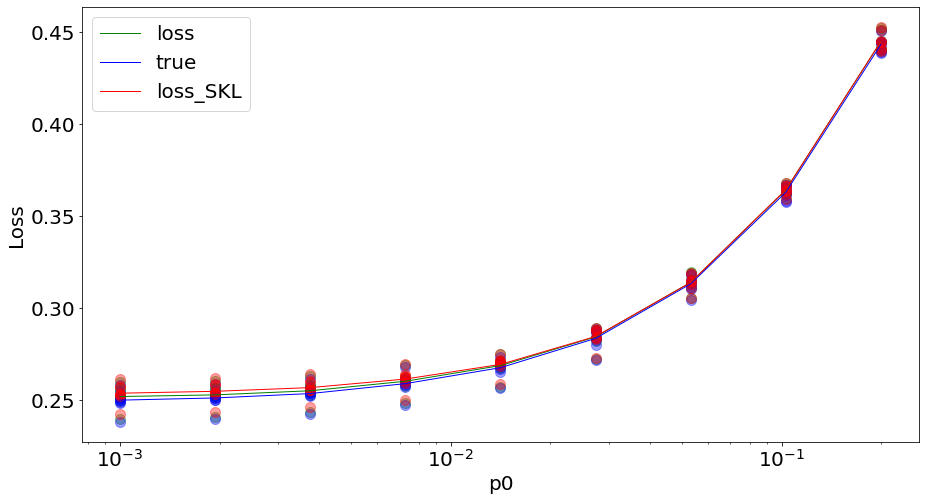

In [40]:
fig, ax = plot_explore_param(variable='p0', var_range=p0s, results=results)

As expected, the lapse rate `p0`as an influence on the cost: when low ($p0<0.01$), cost are similar. When higher, the two methods diverge and our method is obviously better.

After this quantitative comparison of the methods, let's now study how the methods compare when retrieving the parameters.

## comparing the predicted values

In this section, we will change one parameter after antoher, while keeping the others fixed and check the retrieved value obtained by both methods.


In [41]:
print(
    f"p0 = {p0:.3f}, theta0 = {npa2str(theta0)}, wt = {npa2str(wt)}, theta_max = {theta_max:.3f}"
)

p0 = 0.100, theta0 = 0.000, 0.000, 0.000, 0.000, 0.000, wt = 0.098, 0.172, 0.245, 0.319, 0.393, theta_max = 1.571




### changing `p0`

Let's start by changing the lapse rate `p0`:

In [42]:
N_scan = 20
p0s = np.logspace(-3, -0.7, N_scan, base=10, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_indeps, wt_tos, wt_indeps = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

for p0_ in p0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(p0=p0_, seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, ind_condition, y, verbose=False)
        logistic_model_indep, loss_indep = fit_data(theta, ind_condition, y, logit0=logit0_init * torch.ones(N_conditions), verbose=False)

        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_indep, wt_indep = get_params(logistic_model_indep, verbose=False)

        p0s_.append(p0_)
        theta0s_.append(theta0)
        wts_.append(wt)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_indeps.append(theta0_indep)
        wt_tos.append(wt_to)
        wt_indeps.append(wt_indep)

ValueError: too many values to unpack (expected 3)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(p0s_, p0_tos, label="torch")
axs[0].plot([min(p0s_), max(p0s_)], [min(p0_tos), max(p0_tos)], "--")
axs[0].set(xlabel="p0 (true)", ylabel="p0 (predicted)")
axs[0].legend(loc="upper left")

axs[1].scatter(p0s_, theta0_tos, label="torch")
axs[1].scatter(p0s_, theta0_indeps, label="sklearn")
axs[1].plot([min(p0s_), max(p0s_)], [theta0, theta0], "--")
axs[1].set(xlabel="p0", ylabel="theta0 (predicted)")
axs[1].legend(loc="upper left")

axs[2].scatter(p0s_, wt_tos, label="torch")
axs[2].scatter(p0s_, wt_indeps, label="sklearn")
axs[2].plot([min(p0s_), max(p0s_)], [wt, wt], "--")
axs[2].set(xlabel="p0", ylabel="slope (predicted)")
axs[2].legend(loc="upper left")
plt.tight_layout();

Our method is able to fairly accurately retrieve the value of the lapse rate. The errors obtained in the fitting of the other parameters are comparable forr `theta0`but are high on the slope. The slope is clearly overestimated depending on the lapse rate. 



### changing `theta0`


In [ ]:
N_scan = 20
theta0s = .61803 * theta_max * np.linspace(-1, 1, N_scan, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_indeps, wt_tos, wt_indeps = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

for theta0_ in theta0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(theta0=theta0_, seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, ind_condition, y, verbose=False)
        logistic_model_indep, loss_indep = fit_data(theta, ind_condition, y, logit0=logit0_init * torch.ones(N_conditions), verbose=False)

        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_indep, wt_indep = get_params(logistic_model_indep, verbose=False)

        p0s_.append(p0)
        theta0s_.append(theta0_)
        wts_.append(wt)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_indeps.append(theta0_indep)
        wt_tos.append(wt_to)
        wt_indeps.append(wt_indep)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(theta0s_, p0_tos, label="torch")
axs[0].plot([min(theta0s_), max(theta0s_)], [p0, p0], "--", label="true")
axs[0].set(xlabel="theta0 (true)", ylabel="p0 (predicted)", ylim=(.0, .2))
axs[0].legend(loc="upper left")

axs[1].scatter(theta0s_, theta0_tos, label="torch")
axs[1].scatter(theta0s_, theta0_indeps, label="sklearn")
axs[1].plot([min(theta0s_), max(theta0s_)], [min(theta0s_), max(theta0s_)], "--", label="true")
axs[1].set(xlabel="theta0 (true)", ylabel="theta0 (predicted)")
axs[1].legend(loc="upper left")

axs[2].scatter(theta0s_, wt_tos, label="torch")
axs[2].scatter(theta0s_, wt_indeps, label="sklearn")
axs[2].plot([min(theta0s_), max(theta0s_)], [wt, wt], "--", label="true")
axs[2].set(xlabel="theta0 (true)", ylabel="slope (predicted)")
axs[2].legend(loc="upper left")
plt.tight_layout();



### changing `wt`


In [ ]:
N_scan = 20
wts = wt * np.logspace(-1, .5, N_scan, base=4, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_indeps, wt_tos, wt_indeps = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

for wt_ in wts:
    for i_CV in range(N_cv):
        theta, p, y = get_data(wt=wt_, seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, ind_condition, y, verbose=False)
        logistic_model_indep, loss_indep = fit_data(theta, ind_condition, y, logit0=logit0_init * torch.ones(N_conditions), verbose=False)

        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_indep, wt_indep = get_params(logistic_model_indep, verbose=False)

        p0s_.append(p0)
        theta0s_.append(theta0)
        wts_.append(wt_)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_indeps.append(theta0_indep)
        wt_tos.append(wt_to)
        wt_indeps.append(wt_indep)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(wts_, p0_tos, label="torch")
axs[0].plot([min(wts_), max(wts_)], [p0, p0], "--", label="true")
axs[0].set(xlabel="slope (true)", ylabel="p0 (predicted)", ylim=(.0, .3))
axs[0].legend(loc="upper left")

axs[1].scatter(wts_, theta0_tos, label="torch")
axs[1].scatter(wts_, theta0_indeps, label="sklearn")
axs[1].plot([min(wts_), max(wts_)], [theta0, theta0], "--", label="true")
axs[1].set(xlabel="slope (true)", ylabel="theta0 (predicted)", ylim=(-.2, .2))
axs[1].legend(loc="upper left")

axs[2].scatter(wts_, wt_tos, label="torch")
axs[2].scatter(wts_, wt_indeps, label="sklearn")
axs[2].plot([min(wts_), max(wts_)], [min(wts_), max(wts_)], "--", label="true")
axs[2].set(xlabel="slope (true)", ylabel="slope (predicted)")
axs[2].legend(loc="upper left")
plt.tight_layout();

Our method is able to fairly accurately retrieve the value of the lapse rate, but the precision decreases with the lapse rate. The errors obtained in the fitting of the other parameters are comparable forr `theta0` but are high on the slope. The slope is clearly overestimated in the case of the classical logistic regression. 


### changing `wt` with a null lapse rate (`p0=0`)

Let's decompose the effect of using `torch` to using `sklearn`


In [ ]:
N_scan = 20
wts = wt * np.logspace(-1, .5, N_scan, base=4, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_indeps, wt_tos, wt_indeps = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

for wt_ in wts:
    for i_CV in range(N_cv):
        theta, p, y = get_data(wt=wt_, p0=0, seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, ind_condition, y, verbose=False)
        logistic_model_indep, loss_indep = fit_data(theta, ind_condition, y, logit0=logit0_init * torch.ones(N_conditions), verbose=False)

        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_indep, wt_indep = get_params(logistic_model_indep, verbose=False)

        p0s_.append(p0)
        theta0s_.append(theta0)
        wts_.append(wt_)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_indeps.append(theta0_indep)
        wt_tos.append(wt_to)
        wt_indeps.append(wt_indep)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(wts_, p0_tos, label="torch")
axs[0].plot([min(wts_), max(wts_)], [0, 0], "--", label="true")
axs[0].set(xlabel="slope (true)", ylabel="p0 (predicted)")
axs[0].legend(loc="upper left")

axs[1].scatter(wts_, theta0_tos, label="torch")
axs[1].scatter(wts_, theta0_indeps, label="sklearn")
axs[1].plot([min(wts_), max(wts_)], [theta0, theta0], "--", label="true")
axs[1].set(xlabel="slope (true)", ylabel="theta0 (predicted)", ylim=(-.2, .2))
axs[1].legend(loc="upper left")

axs[2].scatter(wts_, wt_tos, label="torch")
axs[2].scatter(wts_, wt_indeps, label="sklearn")
axs[2].plot([min(wts_), max(wts_)], [min(wts_), max(wts_)], "--", label="true")
axs[2].set(xlabel="slope (true)", ylabel="slope (predicted)")
axs[2].legend(loc="upper left")
plt.tight_layout();

This again shows that the slope is better matched with the method presented in this notebook. 

In [ ]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,torch,sklearn,matplotlib  -r -g -b